In [80]:
import numpy as np
from numpy import pi
from scipy.optimize import minimize_scalar, minimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import qiskit as qk
from qiskit import BasicAer, execute
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import NumPyMinimumEigensolver

# Aim: Find lowest eigen value for U

Given :

$$ U = \begin{bmatrix}1 &0 &0 &0 \\0 &0 &-1 &0\\0 &-1 &0 &0\\0 &0 &0 &1\end{bmatrix}$$


Since U is 4x4 we will need 2 qubit circuit, thus the decomposition will be made of tensor products of 2 Pauli operators.

### 1. Reperesent U in terms of Pauli matrices

by inspection:
$$
U = 1/2 (I_{1} \otimes I_{2} + Z_{1} \otimes Z_{2}) -1/2 (X_{1} \otimes X_{2} + Y_{1} \otimes Y_{2})
$$

Since we need to find min eigen value of U using VQE, hamiltonian H = U

## Using classical method to find minimum eigen value

In [81]:
a = np.array
hamiltonian = SparsePauliOp.from_list([("II", 0.5), ("XX", -0.5), ("YY", -0.5), ("ZZ", 0.5)])
hmat = hamiltonian.to_matrix()
hmat

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

In [82]:
min_val_for_hamiltonian = NumPyMinimumEigensolver().compute_minimum_eigenvalue(hamiltonian)
min_val_for_hamiltonian.eigenvalue

print(f"Min value of the hamiltonian using Classical Method: {min_val_for_hamiltonian.eigenvalue}")

Min value of the hamiltonian using Classical Method: -1.0


### 2. Measurment in different basis:

$$
X = HZH
Y = (HS^\dag)^\dag Z (HS^\dag)
$$

### Measurement in ZZ basis

Note: Since here we are dealing with 2 qubit states, the eigen value for 00 and 11 is 1 and for 01 and 10 is -1. 
This is same as XOR, and in quantum circuit XOR can be implemented using CNOT.

In [83]:
qc = qk.QuantumCircuit(2, 1)
qc.barrier()
qc.cnot(0, 1)
qc.measure(1, 0)
qc.draw()

░         
q_0: ─░───■─────
      ░ ┌─┴─┐┌─┐
q_1: ─░─┤ X ├┤M├
      ░ └───┘└╥┘
c: 1/═════════╩═
              0

### Measurment in XX basis

$$ X= HZH $$

In [84]:
qc = qk.QuantumCircuit(2, 1)
qc.barrier()
qc.h(0)
qc.h(1)
qc.cnot(0, 1)
qc.measure(1, 0)

qc.draw()

░ ┌───┐        
q_0: ─░─┤ H ├──■─────
      ░ ├───┤┌─┴─┐┌─┐
q_1: ─░─┤ H ├┤ X ├┤M├
      ░ └───┘└───┘└╥┘
c: 1/══════════════╩═
                   0

### Measurment in YY basis
$$ Y = (HS^\dag)^\dag Z (HS^\dag) $$

In [85]:
qc = qk.QuantumCircuit(2, 1)
qc.barrier()
qc.sdg(0)
qc.sdg(1)
qc.h(0)
qc.h(1)
qc.cx(0, 1)
qc.measure(1, 0)

qc.draw()

░ ┌─────┐┌───┐        
q_0: ─░─┤ Sdg ├┤ H ├──■─────
      ░ ├─────┤├───┤┌─┴─┐┌─┐
q_1: ─░─┤ Sdg ├┤ H ├┤ X ├┤M├
      ░ └─────┘└───┘└───┘└╥┘
c: 1/═════════════════════╩═
                          0

### 3. VQE

<ol>
    <li> Define hamiltonian
    <li> Choose ansatz , parameterised by theta </li>
    <li> Use three qc to estimate mean values `X_1X_2, Y_1Y_2, Z_1Z_2`</li>
    <li>Compute expected value of hamiltonian</li>
    <li> Change theta to reach lower energy </li>
</ol>

Hamiltonian :

$$
U = 1/2 (I_{1} \otimes I_{2} + Z_{1} \otimes Z_{2}) -1/2 (X_{1} \otimes X_{2} + Y_{1} \otimes Y_{2})
$$

Ansatz:

Preparing ansatz

In [117]:
def prepare_ansatz(qc, qr, theta):
    """
    Prepares the suggested ansatz

    Arguments
    -----------
    qc:    quantum Circuit
    qr:    quantum Register
    theta: theta for rx gate
    
    Return
    ---------
    qc:    quantum circuit
    """
    qc.h(qr[0])
    qc.cx(qr[0], qr[1])
    qc.rx(theta, qr[0])
    
    return qc

def prepare_ansatz_with_rotations(qc, qr, theta):
    """
    Prepares the suggested ansatz with only rotation gates

    Arguments
    -----------
    qc:    quantum circuit
    qr:    quantum register
    theta: theta for rx gate
    
    Return
    ---------
    qc:    quantum circuit
    """
    qc.rx(theta[0], qr[0])
    qc.ry(theta[1], qr[0])
    qc.rz(theta[2], qr[0])
    
    return qc

qr = qk.QuantumRegister(2, "qr")
cr = qk.ClassicalRegister(1, "cr")
qc = qk.QuantumCircuit(qr, cr)
qc = prepare_ansatz(qc, qr, 0.2)
qc.draw()

┌───┐     ┌─────────┐
qr_0: ┤ H ├──■──┤ Rx(0.2) ├
      └───┘┌─┴─┐└─────────┘
qr_1: ─────┤ X ├───────────
           └───┘           
cr: 1/═════════════════════

In [118]:

def measurments(qc, qr, cr, op):
    """
    Method to measure in different basis

    Arguments
    -----------
    qc:  quantum circuit
    qr:  quantum register
    cr:  classical register
    op:  basis of operation   
    
    Return
    ---------
    qc:  quantum circuit
    """
    if op == "XX":
        qc.h(qr[0])
        qc.h(qr[1])
        qc.cnot(qr[0], qr[1])
        qc.measure(qr[1], cr[0])
    elif op == 'YY':
        qc.sdg(qr[0])
        qc.sdg(qr[1])
        qc.h(qr[0])
        qc.h(qr[1])
        qc.cnot(qr[0], qr[1])
        qc.measure(qr[1], cr[0])
    elif op == "ZZ":
        qc.cnot(qr[0], qr[1])
        qc.measure(qr[1], cr[0])
    else:
        raise ValueError("Incorrect op format")
    
    return qc

def hamiltonian(params):
    """
    Evaulates the Energy of the trial state using the mean values of the operators XX, YY and ZZ.
    H = 1/2 * (Id + ZZ - XX - YY) 
    
    Arguments
    -----------
    params (dict): is an dictionary containing the mean values form the measurements of the operators XX, YY, ZZ;
    
    Return
    ---------
    en (real): energy of the system
    """
    h = (1 + params['ZZ'] - params['XX'] - params['YY'])/2
    print(h)
    return h

def calc_expectation_value(counts, shots):
    """
    Calculates the expectation value

    Arguments
    -----------
    counts: counts result from a circuit execution
    shots:  The number of times the circuit is run
    
    Return
    ---------
    qc: expectation value
    """
    exp_val = 0.0
    for ct in counts:
        sign = +1
        if ct == "1":
            sign = -1
        exp_val = exp_val + sign*counts[ct]/shots
    return exp_val

In [119]:
def vqe(theta, rotations, flag = True):
    """
    Runs the vqe algorithm

    Arguments
    -----------
    theta:      The rotation values for ansatz
    rotations:  If true use suggested ansatz else use ansatz with rotation gates
    flag:       If true print results and return qc list

    Return
    ---------
    energy: Energy of the system
    """
    shots = 8192
    vqe_res = dict()
    qc_list = dict()

    for op in ["XX", "ZZ", "YY"]:
        qr = qk.QuantumRegister(2, "qr")
        cr = qk.ClassicalRegister(1, "cr")
        qc = qk.QuantumCircuit(qr, cr)

        if rotations:
           qc = prepare_ansatz_with_rotations(qc, qr, theta)
        else:
           qc = prepare_ansatz(qc, qr, theta)

        qc.barrier()
        
        qc = measurments(qc, qr, cr, op)

        
        backend = BasicAer.get_backend("qasm_simulator")
        job = execute(qc, backend, shots=shots)
        result = job.result()
        counts = result.get_counts()
        
        exp_val = calc_expectation_value(counts, shots)
        
        vqe_res[op] = exp_val
        qc_list[op] = qc

    print("Somehing: ", vqe_res)
    energy = hamiltonian(vqe_res)

    if flag:
        print("Mean values from measurment results: \n")
        print(f"Theta   Energy       XX        YY         ZZ")
        print(f"{theta }    {energy:.6f}   {vqe_res['XX']:.6f}    {vqe_res['YY']:.6f}   {vqe_res['ZZ']:.6f}")

        return energy, qc_list
    else:
     return energy

In [120]:
theta = 0.2
energy, qc_list = vqe(theta, False)

for op in ['YY', 'ZZ', 'XX']:
    print(f"Quantum circuit for measurment of {op}")
    print(qc_list[op].draw())

Somehing:  {'XX': 1.0, 'ZZ': 0.980712890625, 'YY': -0.980224609375}
0.98046875
Mean values from measurment results: 

Theta   Energy       XX        YY         ZZ
0.2    0.980469   1.000000    -0.980225   0.980713
Quantum circuit for measurment of YY
      ┌───┐     ┌─────────┐ ░ ┌─────┐┌───┐        
qr_0: ┤ H ├──■──┤ Rx(0.2) ├─░─┤ Sdg ├┤ H ├──■─────
      └───┘┌─┴─┐└─────────┘ ░ ├─────┤├───┤┌─┴─┐┌─┐
qr_1: ─────┤ X ├────────────░─┤ Sdg ├┤ H ├┤ X ├┤M├
           └───┘            ░ └─────┘└───┘└───┘└╥┘
cr: 1/══════════════════════════════════════════╩═
                                                0 
Quantum circuit for measurment of ZZ
      ┌───┐     ┌─────────┐ ░         
qr_0: ┤ H ├──■──┤ Rx(0.2) ├─░───■─────
      └───┘┌─┴─┐└─────────┘ ░ ┌─┴─┐┌─┐
qr_1: ─────┤ X ├────────────░─┤ X ├┤M├
           └───┘            ░ └───┘└╥┘
cr: 1/══════════════════════════════╩═
                                    0 
Quantum circuit for measurment of XX
      ┌───┐     ┌─────────┐ ░ ┌───┐        
q

At $\theta$ = 0.2 Energy $\approx$ 0.98. But we need lowest energy of this system, i.e the lowest eigenvalue of the hamiltonian.

We will use the optimizer for this minimization procedure.

## Using an optimizer

In [121]:
minimize_scalar(vqe, args=(False, False), bounds=(0, pi), method='bounded')

Somehing:  {'XX': 1.0, 'ZZ': 0.361572265625, 'YY': -0.356689453125}
0.359130859375
Somehing:  {'XX': 1.0, 'ZZ': -0.38720703125, 'YY': 0.3642578125}
-0.375732421875
Somehing:  {'XX': 1.0, 'ZZ': -0.737060546875, 'YY': 0.740478515625}
-0.73876953125
Somehing:  {'XX': 1.0, 'ZZ': -0.908935546875, 'YY': 0.893310546875}
-0.901123046875
Somehing:  {'XX': 1.0, 'ZZ': -0.955810546875, 'YY': 0.957275390625}
-0.95654296875
Somehing:  {'XX': 1.0, 'ZZ': -0.996826171875, 'YY': 0.99560546875}
-0.9962158203125
Somehing:  {'XX': 1.0, 'ZZ': -0.988037109375, 'YY': 0.986083984375}
-0.987060546875
Somehing:  {'XX': 1.0, 'ZZ': -0.999267578125, 'YY': 0.99951171875}
-0.9993896484375
Somehing:  {'XX': 1.0, 'ZZ': -1.0, 'YY': 1.0}
-1.0
Somehing:  {'XX': 1.0, 'ZZ': -1.0, 'YY': 1.0}
-1.0
Somehing:  {'XX': 1.0, 'ZZ': -1.0, 'YY': 1.0}
-1.0
Somehing:  {'XX': 1.0, 'ZZ': -1.0, 'YY': 1.0}
-1.0
Somehing:  {'XX': 1.0, 'ZZ': -1.0, 'YY': 1.0}
-1.0
Somehing:  {'XX': 1.0, 'ZZ': -0.999755859375, 'YY': 0.999755859375}
-0.99975585

 message: Solution found.
 success: True
  status: 0
     fun: -1.0
       x: 3.1290295833570028
     nit: 26
    nfev: 26

In [122]:
lowest_eigen_val, _ = vqe(3.1199, False)

Somehing:  {'XX': 1.0, 'ZZ': -0.9990234375, 'YY': 0.999755859375}
-0.9993896484375
Mean values from measurment results: 

Theta   Energy       XX        YY         ZZ
3.1199    -0.999390   1.000000    0.999756   -0.999023


So the lowest hamiltonian is given by $$ H _ {\theta = 3.1199} = 1/2 (1 + <ZZ> + <XX> + <YY>) = -.99 \approx -1 $$ 

In [123]:
print(f" Using classical method we get {min_val_for_hamiltonian.eigenvalue} and from quantum vqe method {lowest_eigen_val}")

 Using classical method we get -1.0 and from quantum vqe method -0.9993896484375


## Analysis

For this analysis I am not using the suggested ansatz but the ansatz with rotation gates only.

In [130]:
def energy_expectation(x, y):
    """
    Calculates energy expectation for a range of values
    """
    energy = np.zeros(x.shape)
    for idx, thetas in enumerate(x):
        for ind, theta1 in enumerate(thetas):
            energy[idx][ind] = vqe([np.pi, theta1, y[ind][idx]], True, False)
    return energy

theta1 = np.linspace(0.0, 2*np.pi, 2)
theta2 = np.linspace(0.0, 2*np.pi, 2)

X, Y = np.meshgrid(theta1, theta2)
Z = energy_expectation(X, Y)

Somehing:  {'XX': -0.022705078125, 'ZZ': -1.0, 'YY': 0.001708984375}
0.010498046875
Somehing:  {'XX': -0.004150390625, 'ZZ': -1.0, 'YY': 0.00244140625}
0.0008544921875
Somehing:  {'XX': -0.001708984375, 'ZZ': -1.0, 'YY': 0.016845703125}
-0.007568359375
Somehing:  {'XX': 0.001220703125, 'ZZ': -1.0, 'YY': -0.01171875}
0.0052490234375


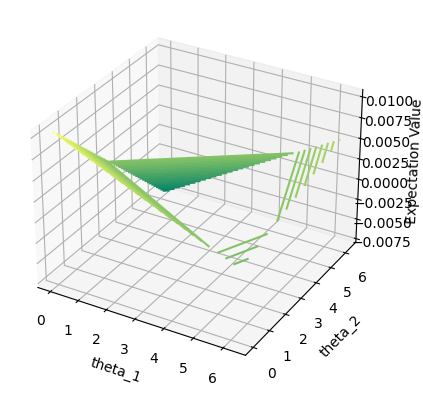

In [131]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap="summer")
ax.set_xlabel('theta_1')
ax.set_ylabel('theta_2')
ax.set_zlabel('Expectation Value')
plt.show()